# open-closed eye detection

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

example

In [3]:
pic=plt.imread("/kaggle/input/mrl-dataset/train/Open_Eyes/s0001_02334_0_0_1_0_0_01.png")


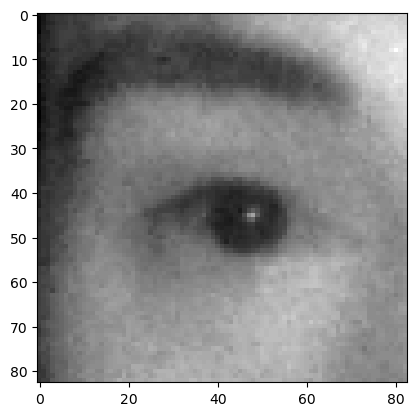

In [4]:
plt.imshow(pic, cmap="gray")

In [5]:
pic.shape

(83, 83)

In [6]:
Datadirectory = '/kaggle/input/mrl-dataset/train'
Classes = ['Closed_Eyes', 'Open_Eyes']
img_size = 100

# Preprocessing and preparation of the data


In [7]:
def apply_data_augmentation(img):
    # Randomly flip the image horizontally
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Randomly flip the image vertically
    if random.random() > 0.5:
        img = cv2.flip(img, 0)

    # Randomly rotate the image by an angle between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))

    # Randomly shift the image horizontally and vertically by up to 10% of the image size
    shift_x = random.randint(-int(0.1 * cols), int(0.1 * cols))
    shift_y = random.randint(-int(0.1 * rows), int(0.1 * rows))
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    img = cv2.warpAffine(img, M, (cols, rows))

    return img

In [8]:

def create_training_data(Classes, Datadirectory, img_size):
    training_data = []
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

            # Resize the image while maintaining the aspect ratio
            desired_size = (img_size, img_size)
            height, width = img_array.shape
            aspect_ratio = width / height

            if aspect_ratio >= 1:
                new_width = desired_size[0]
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = desired_size[1]
                new_width = int(new_height * aspect_ratio)

            resized_image = cv2.resize(img_array, (new_width, new_height))

            # Pad the resized image to make it square (img_size x img_size)
            pad_width = (desired_size[1] - new_height) // 2
            pad_height = (desired_size[0] - new_width) // 2
            padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

            # Normalize the pixel values to [0, 1] using Minmax normalization
            normalized_image = padded_image / 255.0

            # Convert the grayscale image to RGB
            rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
            
            #perform data_augmentation
            #rgb_image = apply_data_augmentation(rgb_image)
            training_data.append([rgb_image, class_num])

    print("Data processing completed.")
    return training_data

In [9]:
training_data = create_training_data(Classes, Datadirectory, img_size)

Data processing completed.


# Shuffle and reshape the data

In [10]:
random.shuffle(training_data)

In [11]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y=np.array(y)

# Building the model

In [12]:
# Define the input shape
input_shape = (100, 100, 3)
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model.add(layers.Flatten())

# Add fully connected layers with specified parameters
model.add(layers.Dense(16384, activation='relu'))
model.add(layers.Dense(180, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [13]:
# Print the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 128)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                    

In [14]:
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Train the model with EarlyStopping callback
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping_callback])

Epoch 1/100
100/100 [==============================] - 25s 82ms/step - loss: 1.2812 - accuracy: 0.6550 - val_loss: 0.6378 - val_accuracy: 0.6837
Epoch 2/100
100/100 [==============================] - 8s 79ms/step - loss: 0.4682 - accuracy: 0.7556 - val_loss: 0.8557 - val_accuracy: 0.5250
Epoch 3/100
100/100 [==============================] - 8s 81ms/step - loss: 0.3020 - accuracy: 0.9253 - val_loss: 0.5129 - val_accuracy: 0.8550
Epoch 4/100
100/100 [==============================] - 8s 80ms/step - loss: 0.1183 - accuracy: 0.9597 - val_loss: 0.0532 - val_accuracy: 0.9800
Epoch 5/100
100/100 [==============================] - 8s 80ms/step - loss: 0.0784 - accuracy: 0.9728 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 6/100
100/100 [==============================] - 8s 81ms/step - loss: 0.0516 - accuracy: 0.9819 - val_loss: 0.0300 - val_accuracy: 0.9887
Epoch 7/100
100/100 [==============================] - 8s 82ms/step - loss: 0.0349 - accuracy: 0.9912 - val_loss: 0.0339 - val_accuracy

# Make predicitons

In [15]:
import cv2
import numpy as np

def preprocess_single_image(image_path, img_size):
    # Read the image in grayscale
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image while maintaining the aspect ratio
    desired_size = (img_size, img_size)
    height, width = img_array.shape
    aspect_ratio = width / height

    if aspect_ratio >= 1:
        new_width = desired_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = desired_size[1]
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(img_array, (new_width, new_height))

    # Pad the resized image to make it square (img_size x img_size)
    pad_width = (desired_size[1] - new_height) // 2
    pad_height = (desired_size[0] - new_width) // 2
    padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

    # Normalize the pixel values to [0, 1] using Minmax normalization
    normalized_image = padded_image / 255.0

    # Convert the grayscale image to RGB
    rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)

    return rgb_image


In [23]:
image_path = "/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Open/_107.jpg"
tttt=plt.imread(image_path)
print(tttt.shape)
preprocessed_image = preprocess_single_image(image_path, img_size)
print(preprocessed_image.shape)
resized_image = cv2.resize(preprocessed_image, (100, 100))
# Reshape the preprocessed image to match the input shape of the model
preprocessed_image = resized_image.reshape(-1, img_size, img_size, 3)

# Make predictions using the model
predictions = model.predict(preprocessed_image)
print(predictions)
# The 'predictions' variable will contain the probability of the image belonging to each class.
# You can use 'np.argmax(predictions)' to get the predicted class index with the highest probability.


(300, 395, 3)
(99, 100, 3)
1/1 [==============================] - 0s 21ms/step
[[0.9997707]]
